# Coding Drill 05

## 1. Target

- Reduce number of parameters < 8K, trying to achieve accuracy within 15 EPOCHs
- Improve accuracy from CodingDrill_04

## 2. Key Updates

- Model: Same as CodingDrill_04
- Training/Augmentation: Main code same as CodingDrill_04
  - Tried with different values of lr and LRScheduler params
  - Best Params 
    - Optimizer: lr=0.05, momentum=0.9
    - scheduler: step_size=6, gamma=0.5

## 3. Result

- Params: `7,738`
- Train Accuracy: `99.09%`
- Test Accuracy : `99.40%`

## 4. Analysis

- The test accuracy is consistent in the last few epochs
- Some lr, gamma values did not work out.
- Able to achieve improved accuracy results with lr and scheduler params change as indicated indicated in the key updates
- Test loss curve is smooth.
- Model is not overfitting. 


# Import Libraries

In [1]:
# import all the required torch functions
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


# Include Data Transformations

- We first start with defining our data transformations.
- We need to think what our data is and how can we augment it to represent  represent correctly which it might not see otherwise. 

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                            #  transforms.Resize((28, 28)),
                            #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                            transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                            # Note the difference between (0.1307) and (0.1307,)
                        ])

# Test Phase transformations
test_transforms = transforms.Compose([
                            #  transforms.Resize((28, 28)),
                            #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])

# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Check for GPU availability

In [4]:
SEED = 1

# CUDA? Check for GPU availability
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# Setup Seed, for reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


# Dataloader Arguments & Test/Train Dataloaders

In [5]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The Model

- Let's start with model from where we achieved < 20K params (Earlier assignment S3) 

In [6]:
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1
              
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)          
        x = self.convblock7(x)            

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params

In [7]:
!pip install torchsummary
from torchsummary import summary

# Once we have GPU ready to access, the next step is getting PyTorch to use for storing data (tensors) and computing on data (performing operations on tensors).
# test if PyTorch has access to a GPU
use_cuda = torch.cuda.is_available()

# if GPU is availble use it, if not use CPU. allocate device and assign n/w to it
device = torch.device("cuda" if use_cuda else "cpu")

# configure the model to be loaded on the device decided above.
model = Net().to(device)

# input image size: 28x28, Input_channels: 1
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 15, 24, 24]           1,080
              ReLU-6           [-1, 15, 24, 24]               0
       BatchNorm2d-7           [-1, 15, 24, 24]              30
           Dropout-8           [-1, 15, 24, 24]               0
            Conv2d-9           [-1, 15, 24, 24]             225
        MaxPool2d-10           [-1, 15, 12, 12]               0
           Conv2d-11           [-1, 15, 10, 10]           2,025
             ReLU-12           [-1, 15, 10, 10]               0
    

# Training and Testing

- Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 
- Let's write train and test functions

In [8]:
# Tqdm is a library in Python which is used for creating Progress Meters or Progress Bars.
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  
  model.train() # set the model with training mode (this is the default mode)

  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init. 
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict. 
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

  return 100*correct/processed

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return 100. * correct / len(test_loader.dataset)


In [9]:
from torch.optim.lr_scheduler import StepLR

# move the model to the required device, GPU if available, if not on CPU.
model = Net().to(device)

# create an optimizer (SGD) with required parameters, 
# model.parameters() - these are the model parameters to optimize, 
# learning-rate lr=0.01 and momentum-0.9
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

# Configure epochs to train for
EPOCHS = 15

prev_train_acc = -1
prev_test_acc = -1
train_accuracy = 0
test_accuracy = 0

# run single epoch as of now.
for epoch in range(EPOCHS):
    print(f'Epoch: {epoch+1}')

    # train the model loaded on the device with the required optimizer
    train_accuracy = train(model, device, train_loader, optimizer, epoch)

    # set to the next lr params
    scheduler.step()

    # we need to evaluate on test data
    test_accuracy = test(model, device, test_loader)


    # check difference from previous accuracies for better understanding
    if -1 == prev_train_acc:
      prev_train_acc = train_accuracy
    if -1 == prev_test_acc:
      prev_test_acc = test_accuracy

    print(f'train_acc_diff: {train_accuracy - prev_train_acc:.3f} test_acc_diff: {test_accuracy - prev_test_acc:.3f} test_train_diff: {test_accuracy - train_accuracy:.3f}\n')
    prev_train_acc = train_accuracy
    prev_test_acc = test_accuracy


Epoch: 1


Loss=0.06110656261444092 Batch_id=468 Accuracy=92.48: 100%|██████████| 469/469 [00:18<00:00, 25.03it/s]



Test set: Average loss: 0.0632, Accuracy: 9801/10000 (98.01%)

train_acc_diff: 0.000 test_acc_diff: 0.000 test_train_diff: 5.527

Epoch: 2


Loss=0.09633144736289978 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:20<00:00, 22.87it/s]



Test set: Average loss: 0.0437, Accuracy: 9871/10000 (98.71%)

train_acc_diff: 5.233 test_acc_diff: 0.700 test_train_diff: 0.993

Epoch: 3


Loss=0.029555680230259895 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:17<00:00, 27.22it/s]



Test set: Average loss: 0.0349, Accuracy: 9885/10000 (98.85%)

train_acc_diff: 0.495 test_acc_diff: 0.140 test_train_diff: 0.638

Epoch: 4


Loss=0.07714579254388809 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:17<00:00, 27.38it/s]



Test set: Average loss: 0.0284, Accuracy: 9918/10000 (99.18%)

train_acc_diff: 0.252 test_acc_diff: 0.330 test_train_diff: 0.717

Epoch: 5


Loss=0.08837270736694336 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:17<00:00, 27.12it/s]



Test set: Average loss: 0.0257, Accuracy: 9926/10000 (99.26%)

train_acc_diff: 0.075 test_acc_diff: 0.080 test_train_diff: 0.722

Epoch: 6


Loss=0.024127962067723274 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:16<00:00, 27.73it/s]



Test set: Average loss: 0.0241, Accuracy: 9910/10000 (99.10%)

train_acc_diff: 0.123 test_acc_diff: -0.160 test_train_diff: 0.438

Epoch: 7


Loss=0.02097216248512268 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:17<00:00, 27.15it/s]



Test set: Average loss: 0.0246, Accuracy: 9923/10000 (99.23%)

train_acc_diff: 0.250 test_acc_diff: 0.130 test_train_diff: 0.318

Epoch: 8


Loss=0.02330726385116577 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:17<00:00, 26.95it/s]



Test set: Average loss: 0.0223, Accuracy: 9923/10000 (99.23%)

train_acc_diff: -0.023 test_acc_diff: 0.000 test_train_diff: 0.342

Epoch: 9


Loss=0.022155342623591423 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:16<00:00, 27.91it/s]



Test set: Average loss: 0.0211, Accuracy: 9929/10000 (99.29%)

train_acc_diff: 0.097 test_acc_diff: 0.060 test_train_diff: 0.305

Epoch: 10


Loss=0.03544562682509422 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:16<00:00, 27.76it/s]



Test set: Average loss: 0.0218, Accuracy: 9938/10000 (99.38%)

train_acc_diff: -0.027 test_acc_diff: 0.090 test_train_diff: 0.422

Epoch: 11


Loss=0.006377721205353737 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:16<00:00, 27.66it/s]



Test set: Average loss: 0.0212, Accuracy: 9925/10000 (99.25%)

train_acc_diff: -0.018 test_acc_diff: -0.130 test_train_diff: 0.310

Epoch: 12


Loss=0.017200039699673653 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:18<00:00, 25.73it/s]



Test set: Average loss: 0.0195, Accuracy: 9939/10000 (99.39%)

train_acc_diff: 0.068 test_acc_diff: 0.140 test_train_diff: 0.382

Epoch: 13


Loss=0.02785535156726837 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:17<00:00, 27.41it/s]



Test set: Average loss: 0.0193, Accuracy: 9934/10000 (99.34%)

train_acc_diff: 0.063 test_acc_diff: -0.050 test_train_diff: 0.268

Epoch: 14


Loss=0.02046031691133976 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:17<00:00, 27.42it/s]



Test set: Average loss: 0.0182, Accuracy: 9943/10000 (99.43%)

train_acc_diff: 0.030 test_acc_diff: 0.090 test_train_diff: 0.328

Epoch: 15


Loss=0.00832266453653574 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:16<00:00, 27.60it/s]



Test set: Average loss: 0.0185, Accuracy: 9940/10000 (99.40%)

train_acc_diff: -0.007 test_acc_diff: -0.030 test_train_diff: 0.305



# Move tesnors to numpy as required

- train_losses is a list, but train_losses[i] is a tensor
- all others are numpy

## APIs to use

- To go from np.array to cpu Tensor    => torch.from_numpy().
- To go from cpu Tensor to gpu Tensor  => .cuda()
- To go from a Tensor that requires_grad to one that does not => .detach() 
- To go from a gpu Tensor to cpu Tensor => .cpu()
- To gp from a cpu Tensor to np.array   => .numpy()

In [10]:
# type(train_losses), type(train_losses[0])

for i, loss in enumerate(train_losses):
  train_losses[i] = loss.detach().cpu().numpy()

# Plot the model's learning progress

- Plot training and test accuracies

Text(0.5, 1.0, 'Test Accuracy')

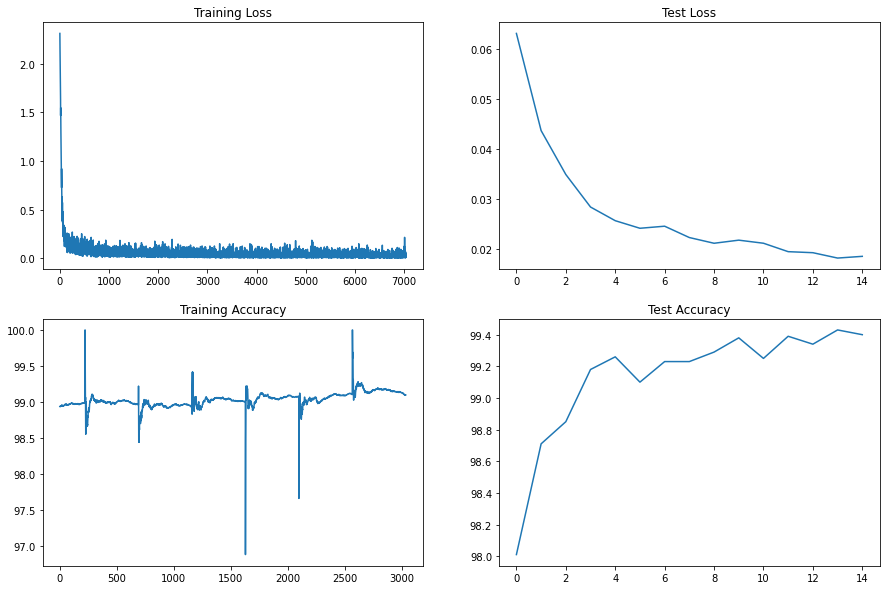

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")